In [2]:
import os
import cv2
import math
import random
import pickle
import imutils
import numpy as np
import pandas as pd
from typing import Any
from threading import Thread
from matplotlib import pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Loads the spreadsheet

In [3]:
SHEET_DATA = pd.read_excel("./data.xlsx")
SHEET_DATA.head()

,filename,treatment,block,row,position,genotype
0,EB00CEE6-848F-4E2A-9A56-C0CD83D55630.jpg,D,1.0,8.0,32.0,BESC-34
1,5AF900F9-D701-4994-95AC-2352420BF18F.jpg,C,1.0,10.0,12.0,"**BESC-417_LM**,core"
2,F7D01515-92CA-4AF5-9BD9-3A4CD99EDF42.jpg,C,2.0,3.0,40.0,BESC-468
3,9117861B-2D2B-4EA8-94B1-D0A862914398.jpg,C,2.0,6.0,54.0,BESC-28_LM
4,D1B282CF-2A10-4458-9E3A-FE08E065A3D6.jpg,C,1.0,24.0,22.0,"**LILD-26-5_LM**,core"


Type Declarations and Helpful Functions

In [4]:
cv2.Image = np.ndarray
cv2.BinaryImage = np.ndarray
cv2.Contour = np.ndarray

# shows an image on ipynb
def imshow(img: np.ndarray) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# easy access grayscale function
def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# get all the contours
def get_contours(img: cv2.Image, debug: bool = False) -> list[cv2.Contour]:
    gray = grayscale(img)
    blur = cv2.GaussianBlur(gray, (51, 51), 0)
    thresh = cv2.threshold(blur, 100, 255, 0)[1]
    if debug: imshow(thresh) 
    return cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

# get a random filename from within the sheet
def get_random_filename() -> str:
    return SHEET_DATA['filename'][random.randint(0, len(SHEET_DATA)-1)]

# get contours that are optimized by the area - to - boudning rect metric, with large contours favored
def get_optimized_contours(contours: list[cv2.Contour], n: int = 1) -> list[cv2.Contour]:
    """ minimize the area of the rectangle and maximize contour area """
    adjusted_contours = []
    for contour in contours:
        _, _, w, h = cv2.boundingRect(contour)
        adjusted_contours.append([contour, cv2.contourArea(contour)**1.5/(w*h)])
    return [x[0] for x in sorted(adjusted_contours, key=lambda x: x[1], reverse=True)[:n]]

# display filename and image, and get image going to filename
def get_image(filename: str = None):
    if filename is None:
        filename = f"dataset/{get_random_filename()}"
    print(filename)
    img = cv2.imread(filename)
    imshow(img)
    return img

### Segment the leaves from the image

Approach 1: Use large contours and an image mask

dataset/850BEC72-E48B-4684-B2C6-5F5834D29748.jpg


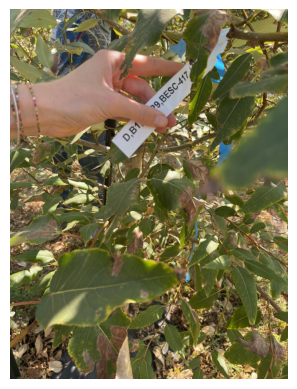

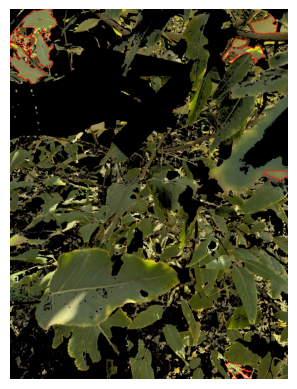

In [108]:
def get_leaves(img: cv2.Image, debug: bool = True) -> Any:
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_img, (20, 70, 60), (80, 255, 255))
    masked = cv2.bitwise_and(img, img, mask=mask)
    biggest_leaves = get_optimized_contours(get_contours(masked, False), n=5)
    masked = cv2.drawContours(masked, biggest_leaves, -1, (0, 0, 255), 5)
    if debug: imshow(masked)

img = get_image()
get_leaves(img, debug=True)

Approach 2: Use Canny Edge detection and image inflation to detect contours

dataset/9B0F1424-0207-4A91-9DE4-7160F4987B0A.jpg


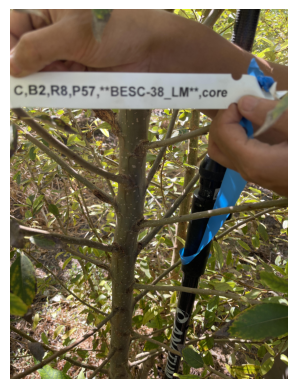

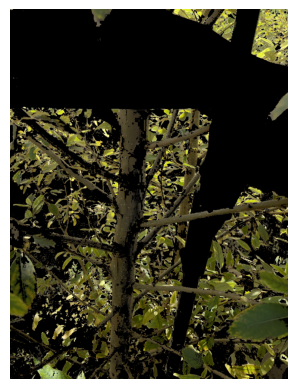

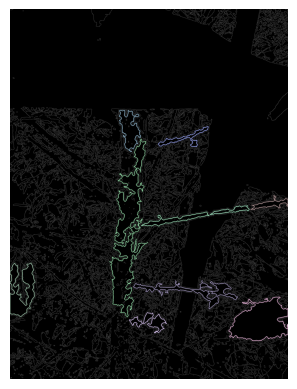

In [5]:
def patchify(img: cv2.BinaryImage, n: int, iters: int) -> Any:
    assert n % 2, "Side length must be odd"
    """ Outputs a square of points around the center (0, 0) with corners removed. """
    new_img = img.copy()
    for _ in range(iters):
        diff = n // 2
        kernel = np.ones((n, n), dtype=np.uint8)
        for y in range(-diff, diff+1):
            for x in range(-diff, diff+1):
                if abs(y) + abs(x) > diff + 1:
                    kernel[y+diff][x+diff] = 0
        new_img = cv2.dilate(new_img, kernel)
    return new_img

def filter_contours(contours: list[cv2.Contour], mask: cv2.BinaryImage) -> list[cv2.Contour]:
    contours = filter(lambda x: len(img) // 10 < max(cv2.boundingRect(x)[-2:]) < len(img) // 2, contours)
    green_colored_contours = []
    for contour in contours: 
        mask_inside_contour = np.zeros_like(mask, np.uint8)
        mask_inside_contour = cv2.drawContours(mask_inside_contour, [contour], -1, 255, -1)
        mean = cv2.mean(mask, mask=mask_inside_contour)
        if mean[0] >= 100:
            green_colored_contours.append(contour)
    contours = get_optimized_contours(green_colored_contours, 15)
    return contours

def draw_contours(contours: list[cv2.Contour], img: cv2.Image, mode: str = "random") -> cv2.Image:
    """ Draw contours onto an image with random colors """
    draw_img = img.copy()
    for contour in contours:
        if mode == "random":
            color = tuple(random.randint(150, 255) for _ in range(3))
        elif mode == "red": 
            color = (0, 0, 255)
        elif mode == "blue":
            color = (255, 0, 0)
        elif mode == "green":
            color = (0, 255, 0)
        else:
            raise Exception("Invalid color mode.")
        draw_img = cv2.drawContours(draw_img, [contour], -1, color, 5)
    return draw_img

def get_leaf_contours(img: cv2.Image, debug: bool = False) -> list[cv2.Contour]:

    # generate a mask for the image (colors we are interested in)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_img, (20, 50, 50), (80, 255, 255))
    masked = cv2.bitwise_and(img, img, mask=mask)
    if debug: imshow(masked)

    # find the edges using the Canny algorithm
    img_blur = cv2.GaussianBlur(masked, (23, 23), sigmaX=0, sigmaY=0) 
    edges = cv2.Canny(img_blur, threshold1=20, threshold2=40)
    dilated = cv2.bitwise_not(patchify(edges, 13, iters=2))

    # find the contours in the resulting image to determine which ones are leaves
    contours = filter_contours(cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0], mask)

    # display found leaves
    if debug:
        drawn_contours = draw_contours(contours, cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR))
        imshow(drawn_contours)

    return contours

img = get_image()
_ = get_leaf_contours(img, debug=True)

#### Train a simple ML model to detect leaves

Feature extraction from leaf

dataset/3D61B945-CA21-42F4-98EA-D8EAC14E97B6.jpg


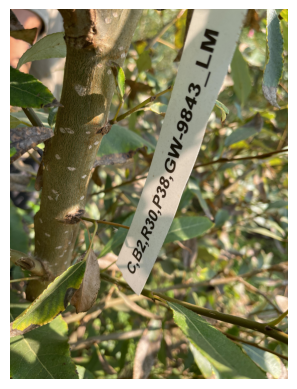

{'area_peri': 0.012155578244029302,
 'area_rect': 0.4946054203031695,
 'area_convex': 0.7275751998075577,
 'area_elli_inter': 1.0810180940052982,
 'ellipse_elli_inter': 1.4675072628794208,
 'h0': 0.7151786694802325,
 'h1': 2.8762532234716325,
 'h2': 2.7589570412857216,
 'h3': 4.163864334556049,
 'h4': 7.842709289636256,
 'h5': 5.718125710508822,
 'h6': -7.724708196705682}

In [6]:
def get_features(contour: cv2.Contour) -> dict[str, float]:

    # get contour moments
    moments = cv2.HuMoments(cv2.moments(contour))
    adjusted_moments = map(lambda x: -math.copysign(1.0, x) * math.log10(abs(x)), [*moments])
    moment_dict = {f'h{i}': m for i, m in enumerate(adjusted_moments)}

    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)

    # the idea here is that ratios are more important than the values themselevs
    # get ratio of area to bounding rect, perimeter, and bounding hull
    area_rect_ratio = area / (w * h)
    area_peri_ratio = area / cv2.arcLength(contour, True) ** 2    # might make it too sensitive :O
    convex_area_ratio = area / cv2.contourArea(cv2.convexHull(contour))

    # ratio of area covered by fit ellipse to contour
    el_mask, cnt_mask = [np.zeros((y+h*3, x+w*3)) for _ in range(2)]
    ellipse = cv2.fitEllipse(contour)
    ellipse_area = float(np.prod(ellipse[1])) * math.pi / 4
    el_mask = cv2.ellipse(el_mask, ellipse, 100, thickness=cv2.FILLED)
    cnt_mask = cv2.drawContours(cnt_mask, [contour], -1, 100, cv2.FILLED)
    total_mask = cv2.threshold((el_mask + cnt_mask).astype(np.uint8), 150, 255, 0)[1]
    merged_contours = cv2.findContours(total_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    total_merged_area = sum(map(cv2.contourArea, merged_contours))

    # ratio of area (in contour and ellipse) to interesct with bounding ellipse
    try:
        area_intersect_ratio = area / total_merged_area
        area_ellipse_intersect_ratio = ellipse_area / total_merged_area
    except ZeroDivisionError:
        area_intersect_ratio = area_ellipse_intersect_ratio = 100000  # big number D:

    # return extracted features
    return {
        'area_peri': area_peri_ratio,
        'area_rect': area_rect_ratio,
        'area_convex': convex_area_ratio,
        'area_elli_inter': area_intersect_ratio,
        'ellipse_elli_inter': area_ellipse_intersect_ratio
    } | moment_dict    

get_features(get_leaf_contours(get_image())[0])

Generating data (subjective, selected by me)

In [ ]:
IMAGE_COUNT = 20

class FeatureThread(Thread):
    def __init__(self, contour):
        Thread.__init__(self)
        self.contour = contour
        self.features = None
    def run(self):
        self.features = get_features(self.contour)

def generate_training_data():
    data = []
    images = [f"dataset/{get_random_filename()}" for _ in range(IMAGE_COUNT)]
    try:
        for filename in images:

            # get the image and the leaf contours
            img = cv2.imread(filename)
            contours = get_leaf_contours(img)

            # go through each leaf
            for contour in contours:

                # start a thread for feature extraction
                thread = FeatureThread(contour)
                thread.start()

                # generate mask of only the leaf being shown
                mask = cv2.drawContours(np.zeros_like(img), [contour], -1, 255, cv2.FILLED)
                masked_img = cv2.bitwise_and(img, img, mask=grayscale(mask))
                imshow(masked_img)
                
                # wait for thread to run during input, join thread, and take data
                is_leaf = input("Is this image leaf-shaped?")
                thread.join()
                data.append(thread.features | {'is_leaf': is_leaf})
                clear_output()
    
    # store data regardless of exit scenario
    finally:
        df = pd.DataFrame(data)
        print(df.head())
        if "leaf_identification" not in os.listdir():
            os.mkdir('leaf_identification')
        df.to_csv('leaf_identification/data.csv', index=False)
        
generate_training_data()

Train the model

In [51]:
# process the data - balance tje dataset by removing extra non-leaves
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df_leaf = df[df['is_leaf'] == 'y']
    df_no_leaf = df[df['is_leaf'] == 'n']
    n = len(df_no_leaf) - len(df_leaf)
    drop_indeces = np.random.choice(df_no_leaf.index, n, replace=False)
    return pd.concat([df_no_leaf.drop(drop_indeces), df_leaf], ignore_index=True)

# get training and testing data
df = preprocess(pd.read_csv("leaf_identification/data.csv"))
y_col = [*map(lambda x: x.lower() == 'y', df.pop('is_leaf'))]
X_train, X_test, y_train, y_test = train_test_split(df, y_col, test_size=0.3)

# adjust the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# train the model and save
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)
with open("leaf_identification/model.pkl", "wb") as f:
    pickle.dump(model, f)
with open("leaf_identification/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):2%}")

Accuracy: 69.230769%


In [52]:
print(*zip(y_test, y_pred), sep="\n")

(True, True)
(True, True)
(True, False)
(True, False)
(True, True)
(True, False)
(True, False)
(True, False)
(False, False)
(False, False)
(True, False)
(True, True)
(True, True)
(True, True)
(False, False)
(False, False)
(False, False)
(True, True)
(False, False)
(True, False)
(True, True)
(False, False)
(False, False)
(False, False)
(True, True)
(True, False)


Load the model and predict on leaf contours

dataset/9823856C-D42F-48EC-A21F-8DDC3D466993.jpg


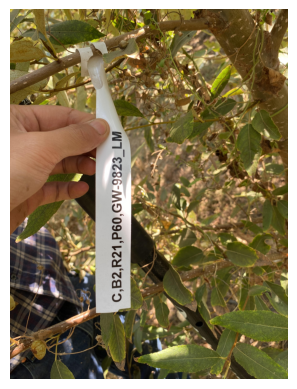

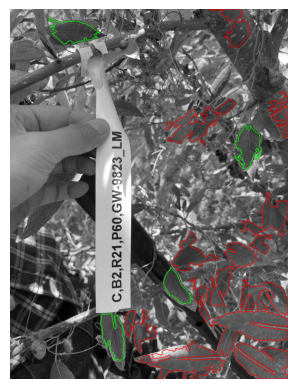

In [7]:
def load_models() -> tuple[RandomForestClassifier, StandardScaler]:
    with open("leaf_identification/model.pkl", 'rb') as f:
        model = pickle.load(f)
    with open("leaf_identification/scaler.pkl", 'rb') as f:
        scaler = pickle.load(f)
    return (model, scaler)

# passes contours through a filter to see the real leaves
def find_real_leaf_contours(img: cv2.Image, model: RandomForestClassifier, scaler: StandardScaler) -> list[cv2.Contour]:
    """ Filters contours through a ML model, returns the 'leaf' contours sorted by highest to lowest confidence """

    CONF_THRESHOLD = 0.70

    # get possible contours, extract features, and predict leaf or not
    contours = get_leaf_contours(img)
    features = scaler.transform(pd.DataFrame([*map(get_features, contours)]))
    predictions = model.predict_proba(features)

    # sift through contours and get the leaves that have the highest chance    
    real_contours, bad_contours = [], []
    for cntr, [_, prob_true] in zip(contours, predictions):
        if prob_true > CONF_THRESHOLD: real_contours.append([cntr, prob_true])
        else: bad_contours.append(cntr)
    sorted_real_contours = [i[0] for i in sorted(real_contours, key=lambda x: x[1], reverse=True)]
    return sorted_real_contours, bad_contours

# loads the ML models and image
model, scaler = load_models()
img = get_image()

# get the contours read and show
good_contours, bad_contours = find_real_leaf_contours(img, model, scaler)
drawn_img = draw_contours(good_contours, cv2.cvtColor(grayscale(img), cv2.COLOR_GRAY2BGR), mode="green")
drawn_img = draw_contours(bad_contours, drawn_img, mode="red")
imshow(drawn_img)

### Crop leaves out and do more feature extraction on for next model

dataset/D4F53AD3-4299-41C5-A31D-670FA677E4AD.jpg


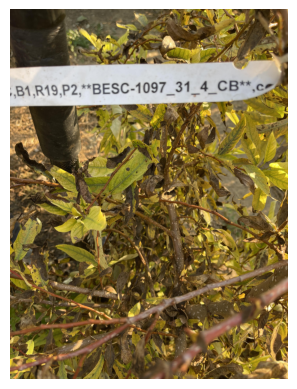

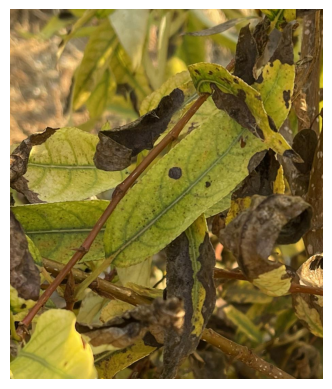

In [35]:
def crop_main_leaf(img: cv2.Image, model: RandomForestClassifier, scaler: StandardScaler) -> cv2.Image:

    EXTRA_SPACE_FACTOR = 0.5
    H_ERR, S_ERR, V_ERR = 20, 30, 50

    # assure a leaf is there
    leaves = find_real_leaf_contours(img, model, scaler)[0]
    if not leaves: return None

    # calculate rectangular params
    main_leaf = leaves[random.choice([*range(len(leaves))])]
    _, _, angle = cv2.minAreaRect(main_leaf)
    x, y, w, h = cv2.boundingRect(main_leaf)

    # calculate adjusted dimensions and angle
    y_min = max(int(y-h*EXTRA_SPACE_FACTOR), 0)
    x_min = max(int(x-w*EXTRA_SPACE_FACTOR), 0)
    y_max = min(int(y+h*(1+EXTRA_SPACE_FACTOR)), len(img))
    x_max = min(int(x+w*(1+EXTRA_SPACE_FACTOR)), len(img[0]))

    # focus on only the area of the leaf in the image
    cropped_img = img[y_min:y_max, x_min:x_max]
    cropped_img_hsv = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2HSV)
    mask = np.zeros((y_max-y_min, x_max-x_min), np.uint8)
    mask = cv2.drawContours(mask, [main_leaf-[x_min, y_min]], -1, 255, cv2.FILLED)
    mean = cv2.mean(cropped_img_hsv, mask=mask)
    return cropped_img

    # use mean to filter by colors
    color_lower = tuple(map(max, [mean[0]-H_ERR, mean[1]-S_ERR, mean[2]-V_ERR], [0, 0, 0]))
    color_upper = tuple(map(min, [mean[0]+H_ERR, mean[1]+S_ERR, mean[2]+V_ERR], [179, 255, 255]))
    blur = cv2.GaussianBlur(cropped_img_hsv, (17, 17), sigmaX=0, sigmaY=0)
    sharpener = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(blur, -1, sharpener)
    col_mask = cv2.inRange(sharpened, color_lower, color_upper)

    return cropped_img

    hull = cv2.convexHull(contours[0])
    imshow(cv2.drawContours(img.copy(), [main_leaf], -1, (0, 0, 255), -1))
    mask = cv2.drawContours(np.zeros_like(cropped_img), [hull-[x_min, y_min]], -1, (255, 255, 255), cv2.FILLED)
    cropped_img_mask = cv2.bitwise_and(cropped_img, mask)
    rotated_img = imutils.rotate_bound(cropped_img, -angle)

    return rotated_img
    
# load model and image
model, scaler = load_models()
img = get_image('dataset/D4F53AD3-4299-41C5-A31D-670FA677E4AD.jpg')

leaf_focus = crop_main_leaf(img, model, scaler)
if leaf_focus is not None: imshow(leaf_focus)

dataset/CC2CB207-C883-4C37-98E6-729074325F89.jpg


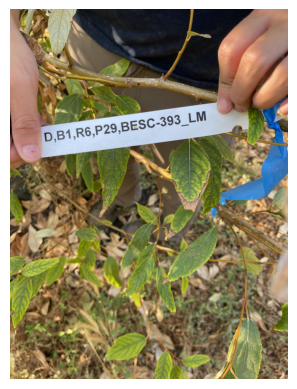

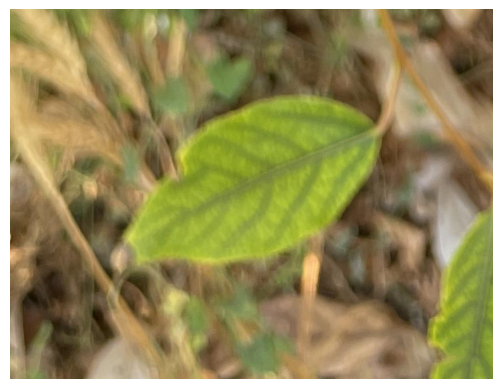

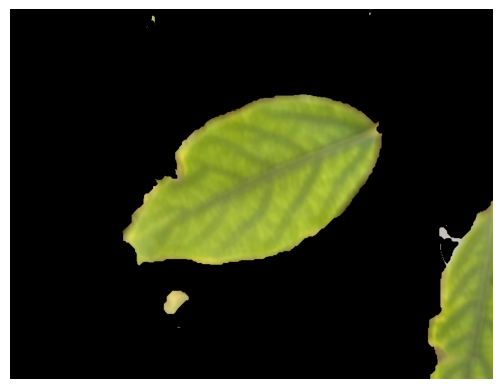

In [50]:
def mask_leaf(im, external_mask=None):

    im = cv2.blur(im, (5,5))

    height, width = im.shape[:2]

    mask = np.ones(im.shape[:2], dtype=np.uint8) * 2 #start all possible background
    '''
    #from docs:
    0 GC_BGD defines an obvious background pixels.
    1 GC_FGD defines an obvious foreground (object) pixel.
    2 GC_PR_BGD defines a possible background pixel.
    3 GC_PR_FGD defines a possible foreground pixel.
    '''

    #2 circles are "drawn" on mask. a smaller centered one I assume all pixels are definite foreground. a bigger circle, probably foreground.
    r = min(height // 7, width // 7)
    cv2.circle(mask, (int(width/2.), int(height/2.)), 2*r, 3, -3) #possible fg
    #next 2 are greens...dark and bright to increase the number of fg pixels.
    mask[(im[:,:,0] < 45) & (im[:,:,1] > 55) & (im[:,:,2] < 55)] = 1  #dark green
    mask[(im[:,:,0] < 190) & (im[:,:,1] > 190) & (im[:,:,2] < 200)] = 1  #bright green

    cv2.circle(mask, (int(width/2.), int(height/2.)), r, 1, -3) #fg

    #if you pass in an external mask derived from some other operation it is factored in here.
    if external_mask is not None:
        mask[external_mask == 1] = 1

    bgdmodel = np.zeros((1,65), np.float64)
    fgdmodel = np.zeros((1,65), np.float64)
    cv2.grabCut(im, mask, None, bgdmodel, fgdmodel, 1, cv2.GC_INIT_WITH_MASK)

    #mask image
    mask2 = np.where((mask==1) + (mask==3), 255, 0).astype('uint8')
    output = cv2.bitwise_and(im, im, mask=mask2)
    imshow(output)

# load model and image
model, scaler = load_models()
img = get_image()

leaf_focus = crop_main_leaf(img, model, scaler)
if leaf_focus is not None: imshow(leaf_focus)

mask_leaf(leaf_focus, external_mask=None)